In [6]:
import gmsh

In [9]:
def create_model(radius, p, name):
    gmsh.initialize()

    center_point = gmsh.model.geo.addPoint(0, 0, 0, p)
    right_point = gmsh.model.geo.addPoint(radius, 0, 0, p)
    left_point = gmsh.model.geo.addPoint(-radius, 0, 0, p)
    top_point = gmsh.model.geo.addPoint(0, radius, 0, p)
    bottom_point = gmsh.model.geo.addPoint(0, -radius, 0, p)

    # Дуги для создания полного круга
    arc1 = gmsh.model.geo.addCircleArc(right_point, center_point, top_point)
    arc2 = gmsh.model.geo.addCircleArc(top_point, center_point, left_point)
    arc3 = gmsh.model.geo.addCircleArc(left_point, center_point, bottom_point)
    arc4 = gmsh.model.geo.addCircleArc(bottom_point, center_point, right_point)

    line = gmsh.model.geo.addLine(top_point, bottom_point)

    curve_loop1 = gmsh.model.geo.addCurveLoop([arc1, arc4, line])
    curve_loop2 = gmsh.model.geo.addCurveLoop([arc2, arc3, -line])

    surface1 = gmsh.model.geo.addPlaneSurface([curve_loop1])
    surface2 = gmsh.model.geo.addPlaneSurface([curve_loop2])

    gmsh.model.addPhysicalGroup(2, [surface1], 1)
    gmsh.model.addPhysicalGroup(2, [surface2], 2)

    gmsh.model.addPhysicalGroup(1, [arc1], 1)
    gmsh.model.addPhysicalGroup(1, [arc2], 2)
    gmsh.model.addPhysicalGroup(1, [arc3], 3)
    gmsh.model.addPhysicalGroup(1, [arc4], 4)

    gmsh.model.geo.synchronize()
    gmsh.model.mesh.generate(2)
    gmsh.option.setNumber("Mesh.MshFileVersion", 2)
    gmsh.write(name)

    gmsh.finalize()


create_model(2, 0.5, './models/m1.msh')
create_model(2, 0.25, './models/m2.msh')
create_model(2, 0.126, './models/correct.msh')

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 40%] Meshing curve 3 (Circle)
Info    : [ 60%] Meshing curve 4 (Circle)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.000787244s, CPU 0.000736s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00382917s, CPU 0.003896s)
Info    : 90 nodes 189 elements
Info    : Writing './models/m1.msh'...
Info    : Done writing './models/m1.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 40%] Meshing curve 3 (Circle)
Info    : [ 60%] Meshing curve 4 (Circle)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.000812664s, CPU 0.001025s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [

In [10]:
import pyvista
print(pyvista.global_theme.jupyter_backend)
pyvista.start_xvfb()
pyvista.set_jupyter_backend("trame")

def show(name):
    p = pyvista.Plotter(window_size=(800, 800))
    mesh = pyvista.read(name)
    p.add_mesh(mesh, show_edges=True)
    if not pyvista.OFF_SCREEN:
        p.view_xy()
        p.show(jupyter_backend='ipykernel')

trame


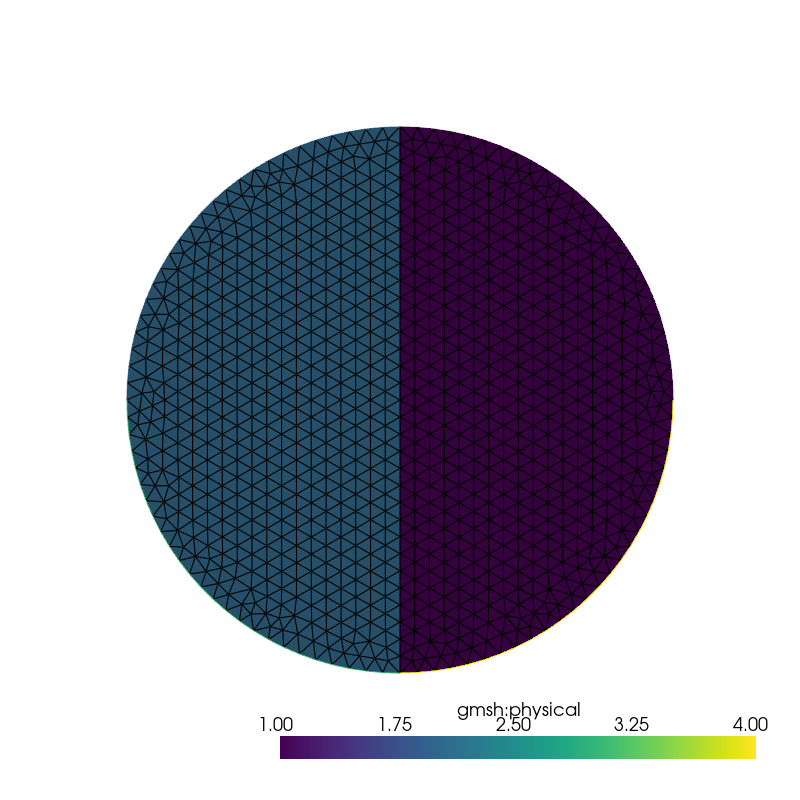

In [11]:
show('./models/correct.msh')

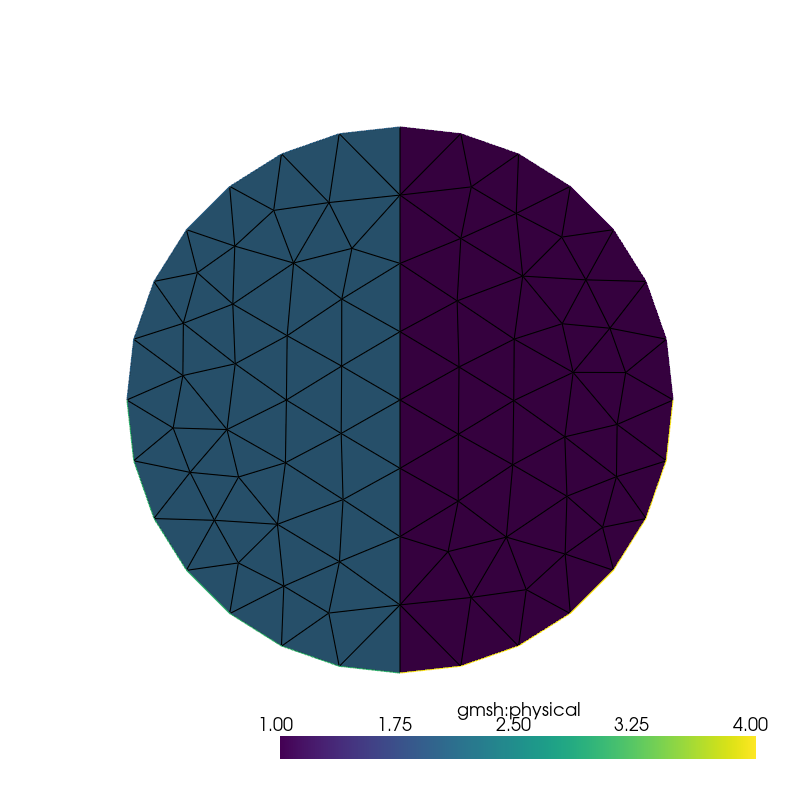

In [12]:
show('./models/m1.msh')

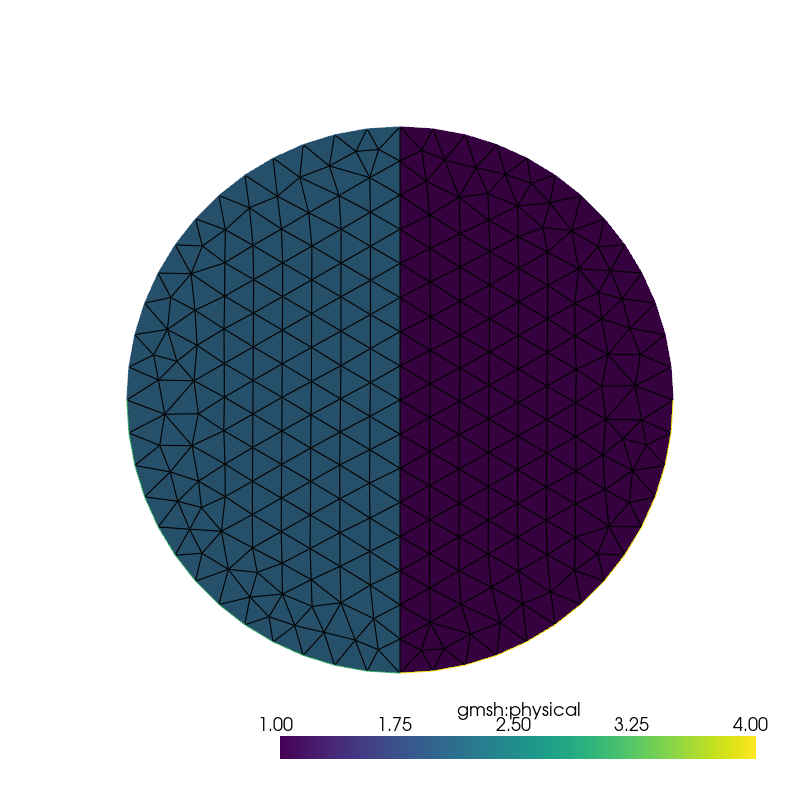

In [13]:
show('./models/m2.msh')

In [14]:
import subprocess

In [15]:
# TODO to meshio
def dolfinConvert(name: str):
    meshfilebasename = f'./models/{name}'
    command = 'dolfin-convert {f}.msh {f}.xml'.format(f=meshfilebasename)
    subprocess.check_call(command.split())

In [16]:
dolfinConvert('m1')
dolfinConvert('m2')
dolfinConvert('correct')

Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified


Expecting 89 vertices
Found all vertices
Expecting 148 cells
Found all cells
Conversion done
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified


Expecting 279 vertices
Found all vertices
Expecting 504 cells
Found all cells
Conversion done
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified


Expecting 1000 vertices
Found all vertices
Expecting 1898 cells
Found all cells
Conversion done


In [23]:
from dolfin import *
from ufl import nabla_div

In [105]:
class Solver():
    def __init__(self, name: str):
        self.__loadMesh(name)
        self.bcs = []
        self.u, self.p = TrialFunctions(self.W)
        self.v, self.q = TestFunctions(self.W)
        
       
        self.T = 1000.0
        self.dt = self.T / 10
        self.k1 = 200
        self.k2 = 10
        self.mu1 = 0.8e9
        self.mu2 = 0.5e9
        self.lambda1 = 1.25e9
        self.lambda2 = 0.65e9
        self.beta1 = 1.0e-5*(3*self.lambda1 + 2 * self.mu1)
        self.beta2 = 1.0e-5*(3*self.lambda2 + 2 * self.mu2)
        self.C = 1.0e6
        self.alpAir = 100.0
        self.TAir = 10.0
        self.THot = 150.0

        self.__loadBoundaries()
  

        self.un_val = Constant((0.0, 0.0))
        self.Tn_val = Constant(self.TAir)

        self.un = interpolate(self.un_val, self.W.sub(0).collapse())
        self.Tn = interpolate(self.Tn_val, self.W.sub(1).collapse())
        self.__loadVelocity()
    def __loadMesh(self, name: str):
        self.mesh = Mesh(f'{name}.xml')
        self.subdomains = MeshFunction('size_t', self.mesh, f'{name}_physical_region.xml')
        self.boundaries = MeshFunction('size_t', self.mesh, f'{name}_facet_region.xml')
        self.V = VectorElement("CG", self.mesh.ufl_cell(), 1)
        self.Q = FiniteElement("CG", self.mesh.ufl_cell(), 1)
        self.TH = self.V * self.Q
        self.W = FunctionSpace(self.mesh, self.TH)
        
        self.dx = Measure('dx', domain = self.mesh, subdomain_data = self.subdomains)
        self.ds = Measure('ds', domain = self.mesh, subdomain_data = self.boundaries)
    def __loadBoundaries(self):
        g0 = Constant(0.0)
        bc_1 = DirichletBC(self.W.sub(0).sub(0), g0, self.boundaries, 4)
        bc_2 = DirichletBC(self.W.sub(0).sub(1), g0, self.boundaries, 1)
        bc_3 = DirichletBC(self.W.sub(0).sub(0), g0, self.boundaries, 3)
        bc_T1 = DirichletBC(self.W.sub(1), self.THot, self.boundaries, 2)
        bc_T2 = DirichletBC(self.W.sub(1), self.THot, self.boundaries, 1)
        bc_T3 = DirichletBC(self.W.sub(1), self.TAir, self.boundaries, 3)
        bc_T4 = DirichletBC(self.W.sub(1), self.TAir, self.boundaries, 4)
        self.bcs = [bc_1, bc_2, bc_3, bc_T1, bc_T2, bc_T3, bc_T4]
    def __loadVelocity(self):
        self.w = Function(self.W)
        d = self.u.geometric_dimension()
        def epsilon(u):
            return 0.5*(nabla_grad(u) + nabla_grad(u).T)
        def sigma(u, lmbda, mu):
            return lmbda*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)
        self.a = inner(sigma(self.u, self.lambda1, self.mu1), epsilon(self.v))*self.dx(1) + self.beta1*inner(grad(self.p), self.v)*self.dx(1)+ self.beta1*self.Tn_val*div(self.u)*self.q*self.dx(1) + self.C*self.p*self.q*self.dx(1) + self.dt*inner(self.k1*grad(self.p), grad(self.q))*self.dx(1) + inner(sigma(self.u, self.lambda2, self.mu2), epsilon(self.v))*self.dx(2) + self.beta2*inner(grad(self.p), self.v)*self.dx(2) + self.beta2*self.Tn_val*div(self.u)*self.q*self.dx(2) + self.C*self.p*self.q*self.dx(2) + self.dt*inner(self.k2*grad(self.p), grad(self.q))*self.dx(2)
        self.L = self.C*self.Tn*self.q*self.dx(1) + self.beta1*self.Tn_val*div(self.un)*self.q*self.dx(1) + self.C*self.Tn*self.q*self.dx(2) + self.beta2*self.Tn_val*div(self.un)*self.q*self.dx(2)

    def solve(self):
        solutions = []
        self.w.rename('u', '0')
        t = 0
        while t < self.T + DOLFIN_EPS:
            t += self.dt
            solve(self.a == self.L, self.w, self.bcs)
            (uu, TT) = self.w.split(deepcopy = True)
            solutions.append(self.w.copy(deepcopy = True))
            self.un.assign(uu)
            self.Tn.assign(TT)
        return solutions

In [106]:
solver = Solver('./models/correct')

In [107]:
solutions = solver.solve()

                        Solving linear variational problem.
                        Solving linear variational problem.
                        Solving linear variational problem.
                        Solving linear variational problem.
                        Solving linear variational problem.
                        Solving linear variational problem.
                        Solving linear variational problem.
                        Solving linear variational problem.
                        Solving linear variational problem.
                        Solving linear variational problem.


In [108]:
uf = File("results/velocity.pvd")
pf = File("results/pressure.pvd")
for solve in solutions:
    u1, p1 = solve.split()
    uf << u1
    pf << p1

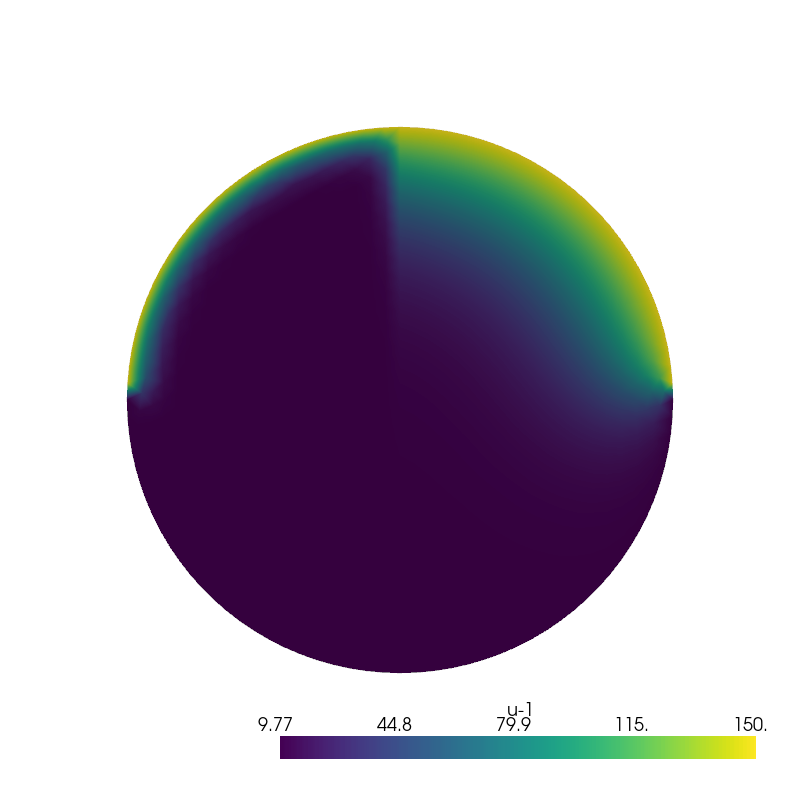

In [110]:
p = pyvista.Plotter(window_size=(800, 800))
mesh = pyvista.read('results/pressure.pvd')
p.add_mesh(mesh, scalars='u-1',)
p.view_xy()
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend='ipykernel')

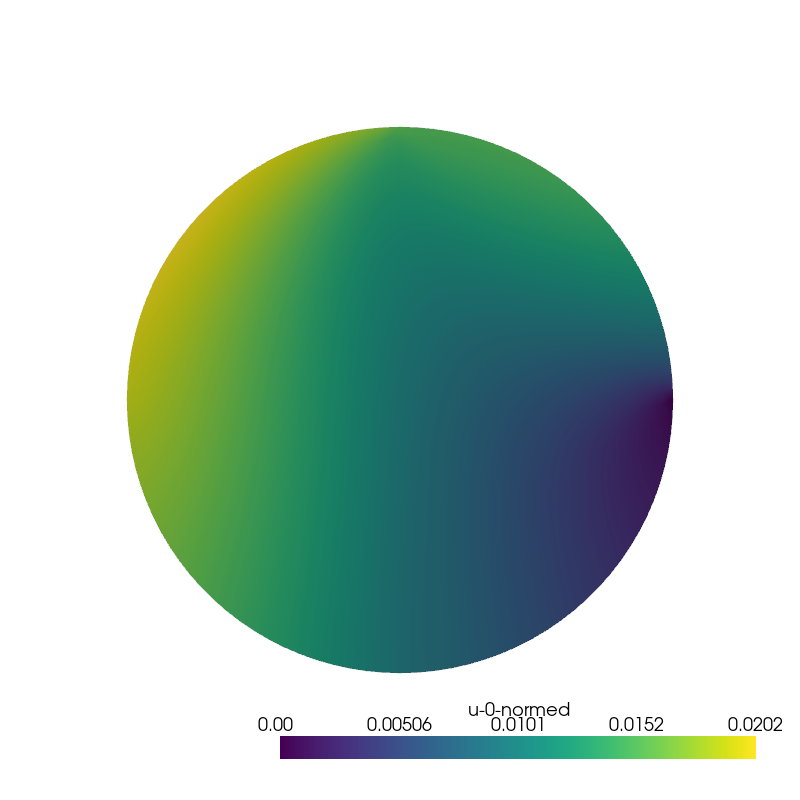

In [111]:
p = pyvista.Plotter(window_size=(800, 800))
mesh = pyvista.read('results/velocity.pvd')
p.add_mesh(mesh, scalars='u-0',)
p.view_xy()
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend='ipykernel')